<a href="https://colab.research.google.com/github/victorbahlangene/Fastai-part-2-2022/blob/main/12_accel_sgd_gpu_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerated SGD

In [1]:
!pip install -Uqq git+https://github.com/fastai/course22p2

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 12.9 MB/s eta 0:00

In [3]:
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [4]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [5]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [6]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [14]:
%matplotlib inline

## Optimizers

### SGD

In [9]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [10]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.825,0.477,0,eval
0.845,0.424,1,train
0.849,0.418,1,eval
0.865,0.372,2,train
0.852,0.401,2,eval


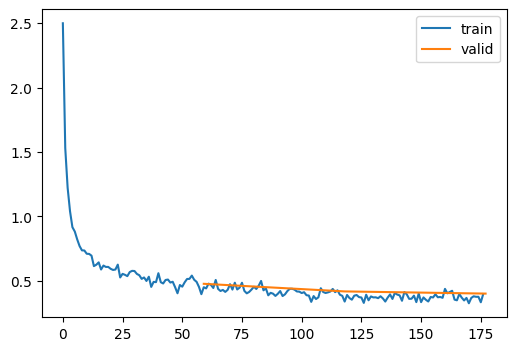

In [11]:
learn.fit(3)

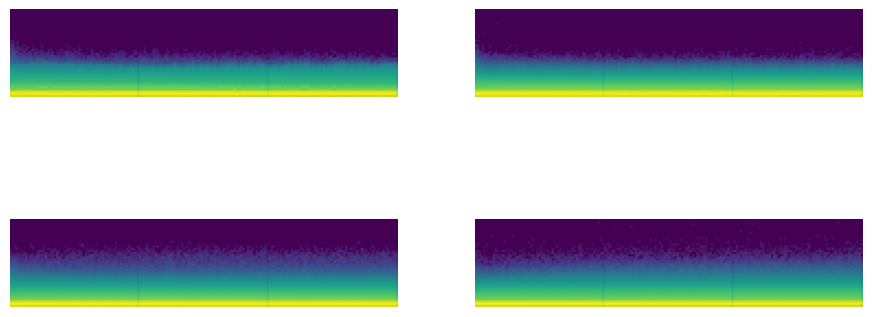

In [17]:
astats.color_dim()

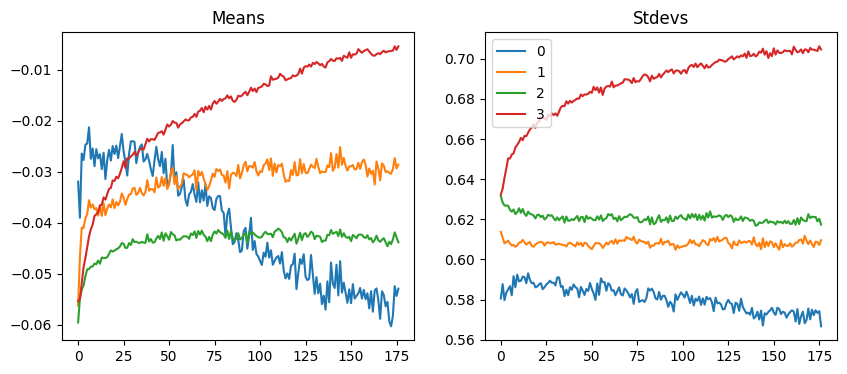

In [16]:
astats.plot_stats()

Consider the difference between weight decay and L2 regularization:

```python
weight -= lr*wd*weight
```
...vs...

```python
weight.grad += wd*weight
```

#### Momentum

In [19]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

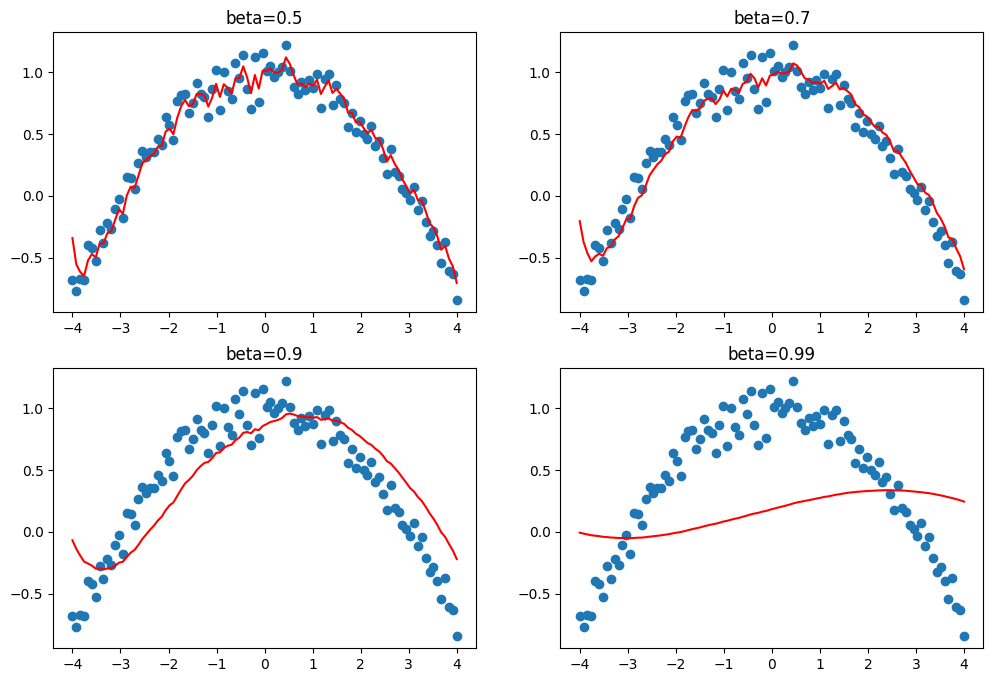

In [20]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [21]:
class Momentum(SGD):
  def __init__(self, params, lr, wd=0., mom=0.9):
    super().__init__(params, lr=lr, wd=wd)
    self.mom=mom

  def opt_step(self, p):
    if not hasattr(p, "grad_avg"): p.grad_avg = torch.zeros_like(p.grad)
    p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
    p -= self.lr * p.grad_avg

In [22]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.787,0.597,0,train
0.847,0.417,0,eval
0.868,0.360,1,train
0.860,0.370,1,eval
0.886,0.314,2,train
0.869,0.358,2,eval


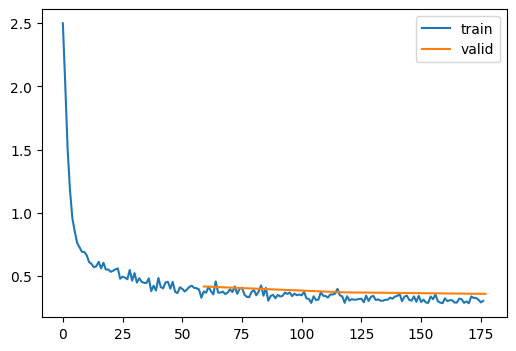

In [23]:
learn.fit(3)

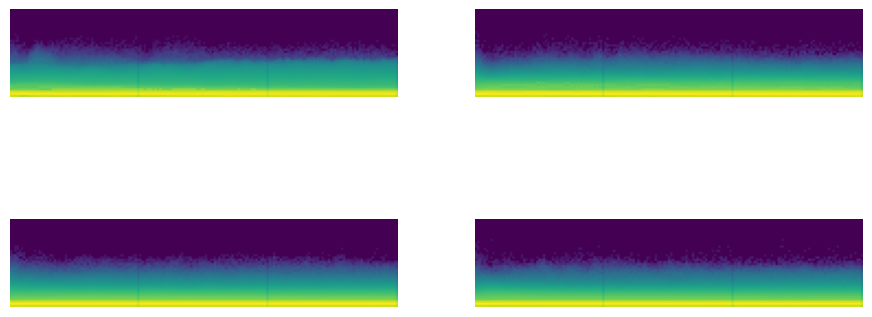

In [24]:
astats.color_dim()

#### RMSProp

In [25]:
class RMSProp(SGD):
  def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
    super().__init__(params, lr=lr, wd=wd)
    self.sqr_mom,self.eps = sqr_mom,eps

  def opt_step(self, p):
    if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
    p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
    p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.765,0.664,0,train
0.823,0.482,0,eval
0.848,0.416,1,train
0.846,0.425,1,eval
0.866,0.368,2,train
0.853,0.401,2,eval


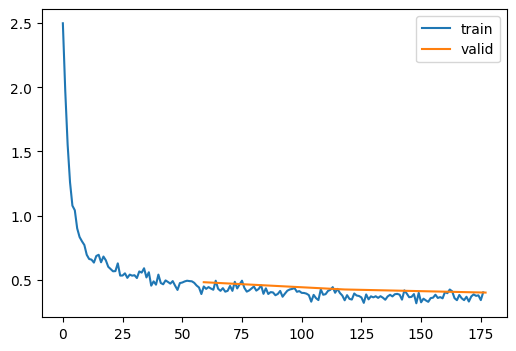

In [26]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

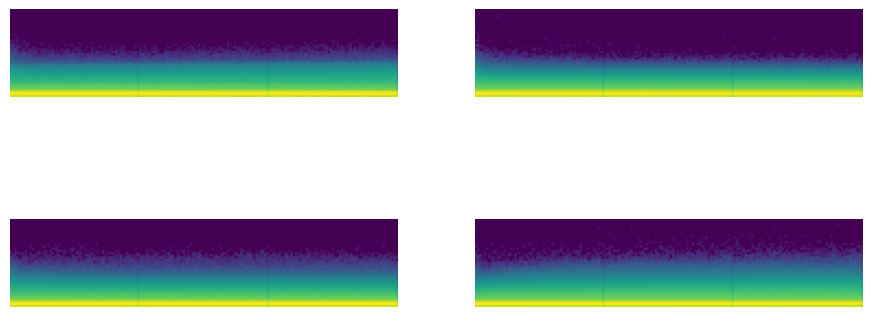

In [27]:
astats.color_dim()

#### Adam

In [28]:
class Adam(SGD):
  def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
      super().__init__(params, lr=lr, wd=wd)
      self.beta1,self.beta2,self.eps = beta1,beta2,eps

  def opt_step(self, p):
    if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
    if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
    p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
    unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
    p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
    unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
    p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.791,0.583,0,train
0.839,0.428,0,eval
0.869,0.359,1,train
0.859,0.381,1,eval
0.886,0.312,2,train
0.874,0.345,2,eval


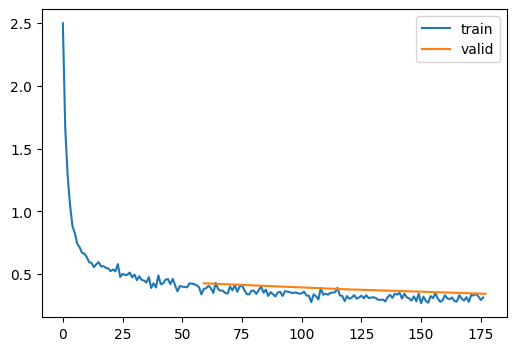

In [29]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

## Schedulers

We've already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [30]:
lr_scheduler

<module 'torch.optim.lr_scheduler' from '/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py'>

In [31]:
dir(lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LRScheduler',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_enable_get_lr_call',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [32]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [33]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [34]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [35]:
opt = learn.opt
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [36]:
dir(opt)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cuda_graph_capture_health_check',
 '_init_group',
 '_optimizer_step_code',
 '_optimizer_step_post_hooks',
 '_optimizer_step_pre_hooks',
 '_patch_step_function',
 '_warned_capturable_if_run_uncaptured',
 '_zero_grad_profile_name',
 'add_param_group',
 'defaults',
 'load_state_dict',
 'param_groups',
 'profile_hook_step',
 'register_step_post_hook',
 'register_step_pre_hook',
 'state',
 'state_dict',
 'step',
 'zero_grad']

In [37]:
" ".join(o for o in dir(opt) if o[0]!="_")

'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [38]:
param = next(iter(learn.model.parameters()))
param

Parameter containing:
tensor([[[[ 0.15, -0.19,  0.08],
          [-0.01, -0.06,  0.26],
          [ 0.16, -0.30,  0.23]]],


        [[[ 0.05,  0.14,  0.03],
          [ 0.33,  0.18, -0.04],
          [-0.31,  0.18, -0.31]]],


        [[[ 0.18,  0.06,  0.13],
          [ 0.10, -0.25, -0.14],
          [-0.07, -0.31,  0.22]]],


        [[[-0.16, -0.16, -0.12],
          [ 0.18, -0.00,  0.15],
          [ 0.17, -0.01,  0.27]]],


        [[[ 0.16,  0.19,  0.33],
          [ 0.13,  0.27,  0.18],
          [-0.14,  0.01, -0.17]]],


        [[[ 0.26,  0.10, -0.23],
          [ 0.30,  0.19,  0.02],
          [-0.24, -0.16, -0.30]]],


        [[[-0.22,  0.32, -0.02],
          [ 0.29,  0.17,  0.30],
          [ 0.11, -0.19,  0.31]]],


        [[[-0.28,  0.09,  0.09],
          [ 0.22, -0.24,  0.12],
          [ 0.04, -0.24,  0.05]]]], device='cuda:0', requires_grad=True)

In [39]:
st = opt.state[param]

In [40]:
st

{'momentum_buffer': None}

In [41]:
len(opt.param_groups)

1

In [42]:
pg = opt.param_groups[0]

In [43]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [45]:
# lr_scheduler.CosineAnnealingLR??

In [46]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [47]:
sched.base_lrs

[0.006]

In [48]:
sched.get_last_lr()

[0.006]

In [49]:
sched.optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.006
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [50]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

In [51]:
sched

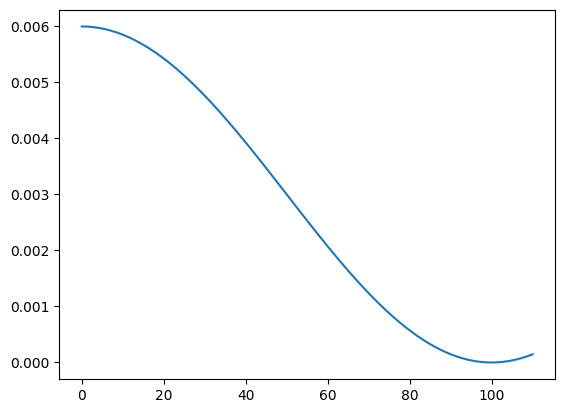

In [52]:
sched_lrs(sched, 110)

### Scheduler callbacks

In [53]:
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [54]:
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [55]:
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn
    def after_fit(self, learn): self.learn = None

In [56]:
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]

    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [57]:
def _lr(cb): return cb.pg['lr']

In [58]:
len(dls.train)

59

In [59]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.806,0.525,0,train
0.848,0.413,0,eval
0.878,0.331,1,train
0.878,0.331,1,eval
0.897,0.282,2,train
0.880,0.318,2,eval


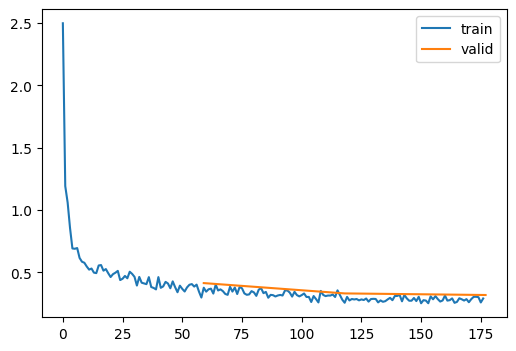

In [60]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

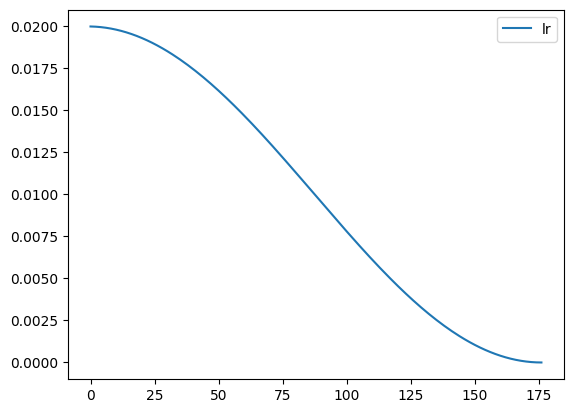

In [61]:
rec.plot()

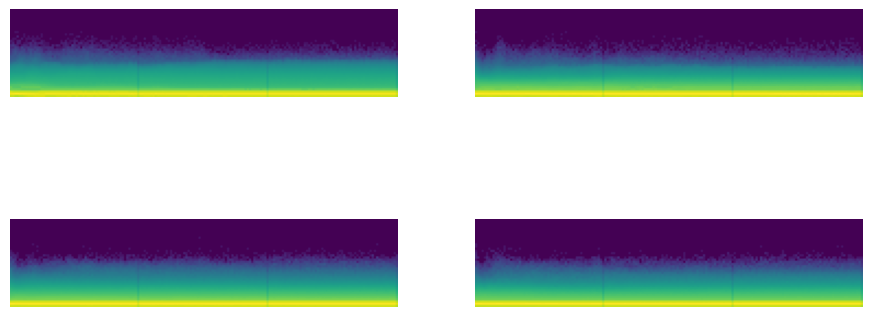

In [62]:
astats.color_dim()

In [64]:
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

accuracy,loss,epoch,train
0.806,0.524,0,train
0.859,0.379,0,eval
0.880,0.328,1,train
0.872,0.334,1,eval
0.898,0.274,2,train
0.883,0.308,2,eval


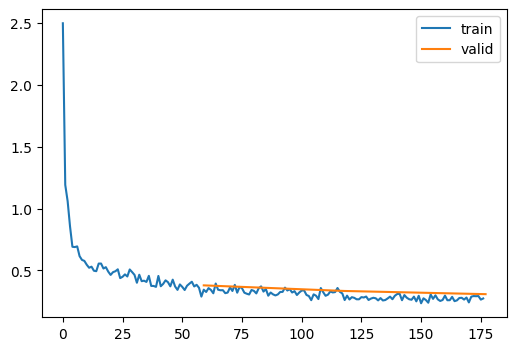

In [65]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

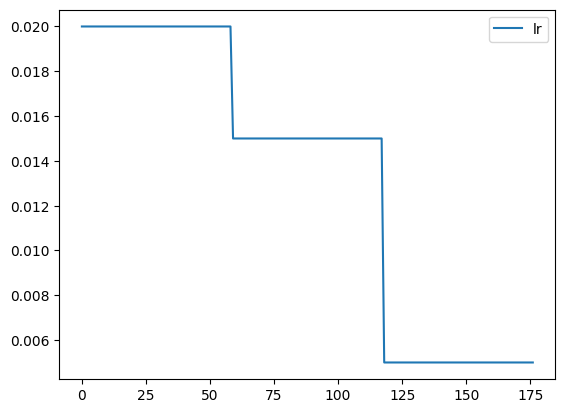

In [66]:
rec.plot()

### 1cycle training

by Leslie Smith

In [67]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.767,0.659,0,train
0.847,0.447,0,eval
0.858,0.386,1,train
0.858,0.398,1,eval
0.885,0.308,2,train
0.882,0.325,2,eval
0.907,0.251,3,train
0.896,0.287,3,eval
0.921,0.213,4,train
0.903,0.269,4,eval


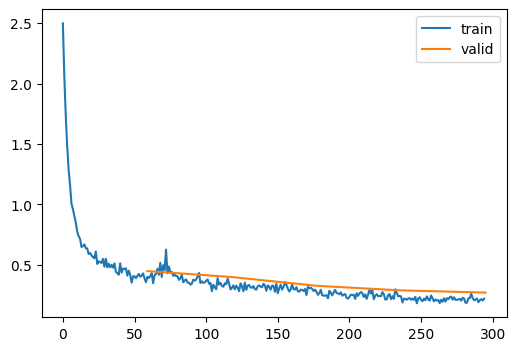

In [68]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

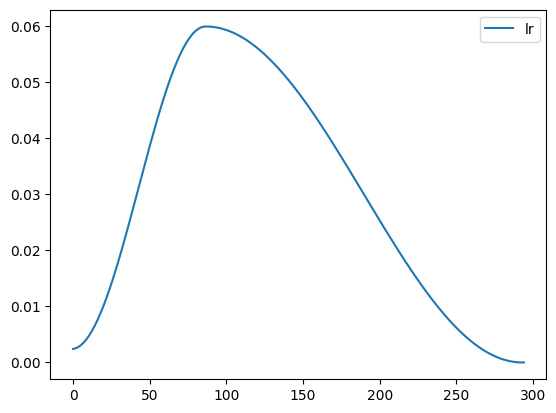

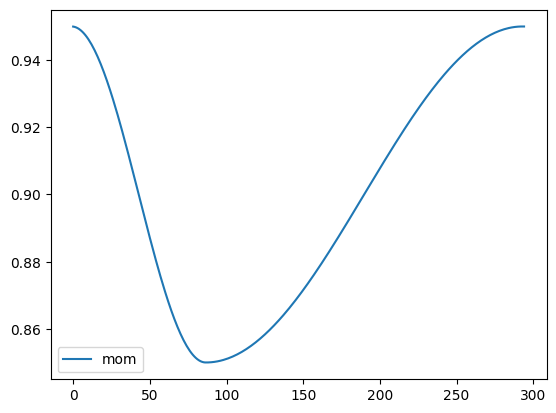

In [69]:
rec.plot()